In [1]:
import importlib
import numpy as np

# files part of this library
import ParseING11 
import CheckConfigs 
import ValidLSJ
import RunCowanRCN

importlib.reload(ParseING11)
importlib.reload(RunCowanRCN)
importlib.reload(CheckConfigs)
importlib.reload(ValidLSJ)

<module 'ValidLSJ' from 'c:\\Users\\brewster\\Desktop\\CowanFrontend\\ValidLSJ.py'>

We start with the input configurations that will go into cowan IN36 files which we define as a function of m. As many lines as necesarry can be defined.

In [ ]:
def line1(m):
    return [f"   50",f"{m+6}Sn{m+5}+", f"4p64d{9-m}", f"3d10 4s2 4p6 4d{9-m}"]
def line2(m):
    return [f"   50",f"{m+6}Sn{m+5}+", f"4p54d{10-m}", f"3d10 4s2 4p5 4d{10-m}"]
def line3(m):
    return [f"   50",f"{m+6}Sn{m+5}+", f"4p64d{8-m}4f1", f"3d10 4s2 4p6 4d{8-m} 4f1"]

lines = [line1, line2, line3]

for m in range(0, 8): # m = 8 has an exception since 8 - m = 0
    # write the in 36 file
    mainstr = RunCowanRCN.write36(lines, m)
    filename = f"C:\\Users\\brewster\\Desktop\\CowanFrontend\\InputOutputCowan\\IN36"
    with open(filename, "w") as f:
        f.write(mainstr)

    # run cowan with in36 file and already existent In2 file
    RunCowanRCN.run_shell_script()

    #rename the files to txt files with index m 
    RunCowanRCN.totxt(m,"IN36")
    RunCowanRCN.totxt(m,"ING11")
    RunCowanRCN.totxt(m,"OUT2")
    RunCowanRCN.totxt(m,"OUT36")

Running port.sh...
Running RCN.BAT...
RCN.BAT completed successfully.
Running RCN2.BAT...
RCN2.BAT completed successfully.

port.sh completed successfully.
Deleted existing file IN36.txt.
Deleted existing file ING11.txt.
Deleted existing file OUT2.txt.
Deleted existing file OUT36.txt.
Running port.sh...
Running RCN.BAT...
RCN.BAT completed successfully.
Running RCN2.BAT...
RCN2.BAT completed successfully.

port.sh completed successfully.
Deleted existing file IN36.txt.
Deleted existing file ING11.txt.
Deleted existing file OUT2.txt.
Deleted existing file OUT36.txt.
Running port.sh...
Running RCN.BAT...
RCN.BAT completed successfully.
Running RCN2.BAT...
RCN2.BAT completed successfully.

port.sh completed successfully.
Deleted existing file IN36.txt.
Deleted existing file ING11.txt.
Deleted existing file OUT2.txt.
Deleted existing file OUT36.txt.
Running port.sh...
Running RCN.BAT...
RCN.BAT completed successfully.
Running RCN2.BAT...
RCN2.BAT completed successfully.

port.sh completed 

This should have produced all the IN36 ING11 OUT2 and OUT36 files with index m inside the InputOutputCowan folder. We can now scrape these files for Rk integrals and wavefunctions to use in the bauche equation. 

In [8]:
# aligning the scraped data with predicitions of amounts of F, G, zeta etc 
def check(filename):
    parseddata = ParseING11.main(filename) # parsing data from ING11 files 
    alignment = []
    
    for val in parseddata:
        print(val)

    print("\n\n\n")
    # values for our 
    for key, value in parseddata[1].items():
        
        print(key)
        configdict = CheckConfigs.main(key.split()[1]) # our algorithm predicts the amount of Fk Gk zeta ai there should be to help identify the parsed output 
        print("values expected, vs values recieved:", sum(configdict.values()) ,len(value), ) #Number of output values scraped, number of output values predicted
        print(configdict, value)
        alignment.append(len(value) == sum(configdict.values())) # list of bools for checked configurations

    return alignment

for i in range(1):
    filename = f"InputOutputCowan\\ING11_{i}.txt"
    print(f"\n{filename}")
    alignment = check(filename)




InputOutputCowan\ING11_0.txt
{'Sn5+ 4p64d9': '-1353475.442', 'Sn5+ 4p64d84f1': '-1352998.505'}
{'Sn5+ 4p64d9': ['5675090', '336952'], 'Sn5+ 4p54d10': ['65459050', '3978752'], 'Sn5+ 4p64d84f1': ['53368790', '9984861', '6640871', '350652', '6352', '4944183', '2902693', '5363734', '3202634', '2221164']}
{'4p54d10 - 4p64d84': ['80.17835', '47.13865', '0.00005', '0.00005']}
{'Sn5+ 4p64d9 Sn5+ 4p54d10': ['1.29250(', '4P//R1//', '4D)-0.999hr', '-95'], 'Sn5+ 4p64d9 Sn5+ 4p64d84f1': ['1.67100(', '4D//R1//', '4F)-0.996hr', '-72']}




Sn5+ 4p64d9
values expected, vs values recieved: 2 2
{'Eav': 1, 'Fk_ii': 0, 'zeta': 1, 'Fk_ij': 0, 'Gk_ij': 0} ['5675090', '336952']
Sn5+ 4p54d10
values expected, vs values recieved: 2 2
{'Eav': 1, 'Fk_ii': 0, 'zeta': 1, 'Fk_ij': 0, 'Gk_ij': 0} ['65459050', '3978752']
Sn5+ 4p64d84f1
values expected, vs values recieved: 10 10
{'Eav': 1, 'Fk_ii': 2, 'zeta': 2, 'Fk_ij': 2, 'Gk_ij': 3} ['53368790', '9984861', '6640871', '350652', '6352', '4944183', '2902693', '5363734

1 1


In [ ]:
# deprecated
""""

from sympy.physics.wigner import wigner_3j, wigner_6j
# Example calculations
#print(wigner_3j(2, 2, 4, 0, 0, 0))  # Example Wigner 3j symbol
#print(wigner_6j(1, 2, 3, 4, 5, 6))  # Example Wigner 6j symbol

def fk(l1, l2, k):
    if k % 2 != 0:
        return 0
    elif k > min(2*l1,2*l2):
        return 0
    L = l1 + l2
    return (-1)**L*(2*l1 +1)*(2*l2 +1)*wigner_3j(l1, k ,l1, 0, 0, 0)*wigner_3j(l2, k ,l2, 0, 0, 0)*wigner_6j(l2, l1 ,L, l2, l1, k)

def gk(l1, l2, k, S):
    if k < abs(l1 - l2):
        return 0
    if k > l1 + l2:
        return 0
    L = l1 + l2
    return (-1)**S**(2*l1 +1)*(2*l2 +1)*wigner_3j(l1, k ,l2, 0, 0, 0)**2 *wigner_6j(l1, l2 ,L, l1, l2, k)


def parse_parameters(values, count_dict):
    #Split the flat value list into chunks based on count_dict
    parsed = {}
    idx = 0
    for key, count in count_dict.items():
        parsed[key] = [int(values[idx + i]) for i in range(count)]
        idx += count
    return parsed


#def valid_k_values_fk(l1, l2):
#    return list(range(0, 2 * min(2 * l1, 2 * l2) + 1, 2))

#def valid_k_values_gk(l1, l2):
#    start = abs(l1 - l2)
#    return list(range(start, l1 + l2 + 1, 2))
"""

In [ ]:
# The file permitted_ls_terms is a lookup table for the purpose of preserving parity in angular momentum calculations 
#TODO incorporate complete algorithm without lookup table

combinedict = validLSJ.PossibleLSJ('4p54d3')
print(combinedict)
tpl = validLSJ.total_possible_LS(combinedict)
print('Total combined possible LS pairs: ',tpl)

{'4p5': [(0.5, 1)], '4d3': [(0.5, 1), (0.5, 2), (0.5, 3), (0.5, 4), (0.5, 5), (1.5, 1), (1.5, 3)]}
Total combined possible LS pairs:  {(2.0, 4), (1.0, 2), (1.5, 4), (1.0, 4), (2.0, 3), (1.5, 3), (2.0, 2), (1.0, 3), (1.5, 2)}


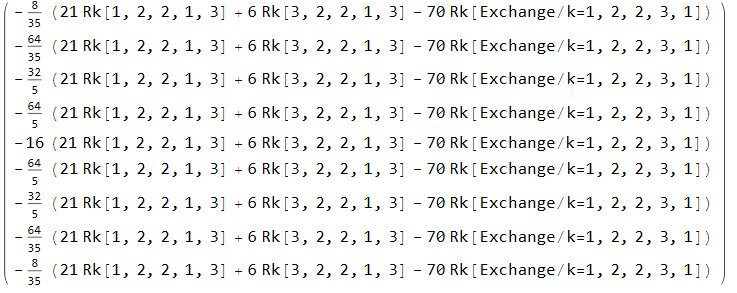

Which is captured by

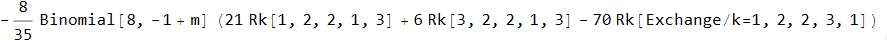


For a specific m we group the k = 1 integrals, and the k = 3 integrals. And we still need to account for the P factors at the end 

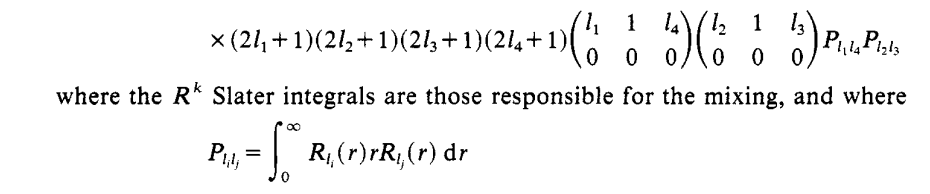

In [ ]:
# this leaves us with (8 choose (m-1)) *( -49 R^1() + 6R^3()) * P_l1,l4 P_l2, l3
# where R^1 and R^3 are the 2 values produces in the m-th ing file and  P_l1 l4 P_l2, l3 are calculated as follows.




ING11_18.txt
Sn13+ 4p64d1
values expected, vs values recieved: 2 2
{'Eav': 1, 'Fk_ii': 0, 'zeta': 1, 'Fk_ij': 0, 'Gk_ij': 0} ['5675090', '509612']
Sn13+ 4p54d2
values expected, vs values recieved: 8 8
{'Eav': 1, 'Fk_ii': 2, 'zeta': 2, 'Fk_ij': 1, 'Gk_ij': 2} ['66121100', '11867751', '8038331', '4892892', '511632', '12348863', '15656824', '9897454']
Sn13+ 4p64f1
values expected, vs values recieved: 2 2
{'Eav': 1, 'Fk_ii': 0, 'zeta': 1, 'Fk_ij': 0, 'Gk_ij': 0} ['72112160', '43382']


In [ ]:
#identify the RK and import them

def rdirect(l1,l2,l3,l4):
    return 0
def rexchange(l1,l2,l3,l4):
    return 1

for m in [1,8,28,56,70]:
    #call ing10 etc



    vi = m * (-12/7 * (rdirect(3,2,0,1,3)) + 8 * rexchange(0,2,0,3,1))
    